# Awareness Modeling


In [159]:
%matplotlib inline
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
from scipy import sparse, stats, spatial
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import NMF, LatentDirichletAllocation


## Import the features from different pickles : 

In [164]:
c_data = pickle.load(open('../DataEnriching/data.pickle','rb'))

lang_feature_df = pd.read_pickle('../LinkingLanguages/stand_country_dist_languages.pkl')
fligh_routes_df = pd.read_pickle('../GeoMetrics/flight_routes_std.pickle')
hop_distance_df = pd.read_pickle('../GeoMetrics/hop_distance_std.pickle')
neighbor_influence_df = pd.read_pickle('../GeoMetrics/neighbor_influence.pickle')
dist_feature_df = pd.read_pickle('../GeoMetrics/real_distance_std.pickle')
religion_and_more_df = pd.read_pickle('../DataEnriching/Pickles for Milestone 3/6_feature_df.pickle')

# drop the name column : 
religion_and_more_df.drop('name',axis=1,inplace=True)

# shift the standardized values :
lang_feature_df = lang_feature_df - lang_feature_df.min().min()
fligh_routes_df = fligh_routes_df - fligh_routes_df.min().min()
hop_distance_df = hop_distance_df - hop_distance_df.min().min()
neighbor_influence_df = neighbor_influence_df - neighbor_influence_df.min().min()
dist_feature_df = dist_feature_df - dist_feature_df.min().min()
#religion_and_more_df = religion_and_more_df - religion_and_more_df.min().min()

#carefull the number of coutries is not the same in every pickle.
features_df = pd.concat([lang_feature_df,
           fligh_routes_df,
           hop_distance_df,
           neighbor_influence_df,
          dist_feature_df,
          religion_and_more_df],axis=1)
features_df.sort_index(axis=1,inplace=True)

features_df[features_df.isnull().any(axis=1)].head(10)

/Users/adrian/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:11: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.


2016_gdp_capita      POP        area flight_routes                      \
                                                   AD   AE   AF        AG   
AD             NaN  85500.0       468.0           inf  inf  inf  0.119521   
AG    14353.378814      NaN       442.0      0.292734  inf  inf       inf   
AI             NaN      NaN        91.0       4.15291  inf  inf   2.07435   
AQ             NaN      NaN  14000000.0           inf  inf  inf       inf   
AS             NaN      NaN       199.0           inf  inf  inf       inf   
AW             NaN      NaN       180.0      0.704395  inf  inf       inf   
AX             NaN      NaN      1580.0           inf  inf  inf       inf   
BL             NaN      NaN        21.0           inf  inf  inf       inf   
BM             NaN      NaN        54.0           inf  inf  inf       inf   
BV             NaN      NaN        49.0           inf  inf  inf       inf   

                           ...      religion                             \
          AI   AL   AM     ...         Islam Jain Judaism Non-religious   
AD  0.243244  inf  inf     ...      0.008999  0.0     0.0        0.0796   
AG  0.292734  inf  inf     ...           NaN  NaN     NaN           NaN   
AI       inf  inf  inf     ...           NaN  NaN     NaN           NaN   
AQ       inf  inf  inf     ...           NaN  NaN     NaN           NaN   
AS       inf  inf  inf     ...           NaN  NaN     NaN           NaN   
AW       inf  inf  inf     ...           NaN  NaN     NaN           NaN   
AX       inf  inf  inf     ...           NaN  NaN     NaN           NaN   
BL       inf  inf  inf     ...           NaN  NaN     NaN           NaN   
BM       inf  inf  inf     ...           NaN  NaN     NaN           NaN   
BV       inf  inf  inf     ...           NaN  NaN     NaN           NaN   

                                                                       
   Other religions Shinto Sikh Syncretic religions Taoism Zoroastrian  
AD          0.0009    0.0  0.0                 0.0    0.0         0.0  
AG             NaN    NaN  NaN                 NaN    NaN         NaN  
AI             NaN    NaN  NaN                 NaN    NaN         NaN  
AQ             NaN    NaN  NaN                 NaN    NaN         NaN  
AS             NaN    NaN  NaN                 NaN    NaN         NaN  
AW             NaN    NaN  NaN                 NaN    NaN         NaN  
AX             NaN    NaN  NaN                 NaN    NaN         NaN  
BL             NaN    NaN  NaN                 NaN    NaN         NaN  
BM             NaN    NaN  NaN                 NaN    NaN         NaN  
BV             NaN    NaN  NaN                 NaN    NaN         NaN  

[10 rows x 1256 columns]

In [165]:
def stand(mylist):
    std_scaler = StandardScaler().fit(np.array(mylist).reshape(-1, 1))
    return std_scaler.transform(np.array(mylist).reshape(-1, 1)) 

In [166]:
# convert every Nan to a 0 
features_df.fillna(value=0,inplace=True)
# replace inf by a large number :
features_df.replace(np.inf, 1E5,inplace=True)

features_df.loc[:,('gov_type_num')] = features_df.loc[:,('gov_type_num')] - features_df.loc[:,('gov_type_num')].min()
features_df.loc[:,('area')] = features_df.loc[:,('area')] - features_df.loc[:,('area')].min()
features_df.index.is_unique

to_standadize = ['2016_gdp_capita','POP','area']
for i in to_standadize:
    
    features_df.loc[:,(i)] = stand(list(features_df.loc[:,(i)]))
    features_df.loc[:,(i)] -=  features_df.loc[:,(i)].min().min()
features_df.head(20)

2016_gdp_capita       POP      area  flight_routes                 \
                                                   AD             AE   
AD        0.000000  0.000722  0.000245  100000.000000  100000.000000   
AE        2.303854  0.052682  0.043702  100000.000000  100000.000000   
AF        0.034401  0.228074  0.340954  100000.000000       2.504397   
AG        0.878951  0.000000  0.000232       0.292734  100000.000000   
AI        0.000000  0.000000  0.000048       4.152905  100000.000000   
AL        0.253942  0.026993  0.015029  100000.000000  100000.000000   
AM        0.220828  0.027418  0.015549  100000.000000       0.447657   
AO        0.190495  0.161461  0.651713  100000.000000       0.712540   
AQ        0.000000  0.000000  7.318500  100000.000000  100000.000000   
AR        0.762347  0.341267  1.453455  100000.000000  100000.000000   
AS        0.000000  0.000000  0.000105  100000.000000  100000.000000   
AT        2.705217  0.070870  0.043844  100000.000000       0.051673   
AU        3.057407  0.180770  4.021006  100000.000000       0.496654   
AW        0.000000  0.000000  0.000095       0.704395  100000.000000   
AX        0.000000  0.000000  0.000826  100000.000000  100000.000000   
AZ        0.237410  0.076427  0.045271  100000.000000       0.306029   
BA        0.288346  0.032300  0.026770  100000.000000  100000.000000   
BB        0.985718  0.002439  0.000225       0.447657  100000.000000   
BD        0.083207  1.244194  0.077143  100000.000000       1.351376   
BE        2.516586  0.091875  0.015959  100000.000000       0.072028   

                                                                               \
               AF             AG             AI             AL             AM   
AD  100000.000000       0.119521       0.243244  100000.000000  100000.000000   
AE       0.096698  100000.000000  100000.000000  100000.000000       0.024626   
AF  100000.000000  100000.000000  100000.000000  100000.000000  100000.000000   
AG  100000.000000  100000.000000       0.292734  100000.000000  100000.000000   
AI  100000.000000       2.074351  100000.000000  100000.000000  100000.000000   
AL  100000.000000  100000.000000  100000.000000  100000.000000  100000.000000   
AM  100000.000000  100000.000000  100000.000000  100000.000000  100000.000000   
AO  100000.000000  100000.000000  100000.000000  100000.000000  100000.000000   
AQ  100000.000000  100000.000000  100000.000000  100000.000000  100000.000000   
AR  100000.000000  100000.000000  100000.000000  100000.000000  100000.000000   
AS  100000.000000  100000.000000  100000.000000  100000.000000  100000.000000   
AT  100000.000000  100000.000000  100000.000000       0.023735       0.079610   
AU  100000.000000  100000.000000  100000.000000  100000.000000  100000.000000   
AW  100000.000000  100000.000000  100000.000000  100000.000000  100000.000000   
AX  100000.000000  100000.000000  100000.000000  100000.000000  100000.000000   
AZ       0.150913  100000.000000  100000.000000  100000.000000  100000.000000   
BA  100000.000000  100000.000000  100000.000000  100000.000000  100000.000000   
BB  100000.000000       0.899517  100000.000000  100000.000000  100000.000000   
BD  100000.000000  100000.000000  100000.000000  100000.000000  100000.000000   
BE  100000.000000  100000.000000  100000.000000  100000.000000  100000.000000   

       ...      religion                                                      \
       ...         Islam Jain   Judaism Non-religious Other religions Shinto   
AD     ...      0.008999  0.0  0.000000      0.079600        0.000900    0.0   
AE     ...      0.674800  0.0  0.000000      0.013599        0.004100    0.0   
AF     ...      0.995600  0.0  0.000000      0.002000        0.001400    0.0   
AG     ...      0.000000  0.0  0.000000      0.000000        0.000000    0.0   
AI     ...      0.000000  0.0  0.000000      0.000000        0.000000    0.0   
AL     ...      0.630000  0.0  0.000000      0.150700        0.002700    0.

## Applying the NMF

In [167]:
features_mat = features_df.as_matrix()


In [168]:
n_samples = np.shape(features_mat)[1]
n_features = 1000
n_components = round(np.shape(features_mat)[1]/7)

In [169]:
W = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit_transform(features_mat)

In [170]:
np.shape(W)

(248, 179)

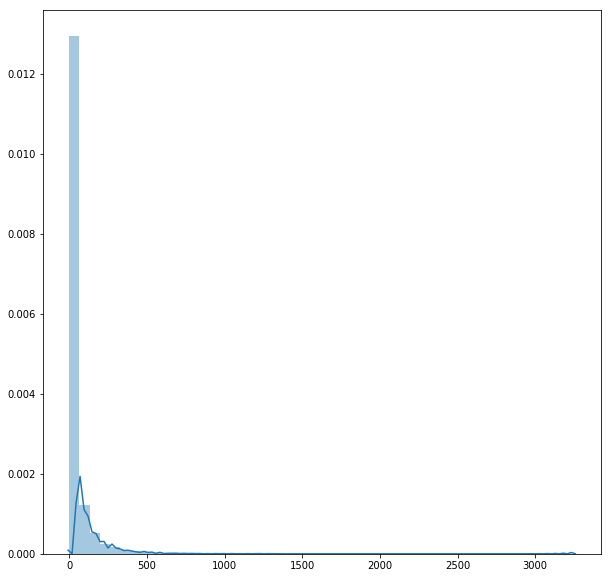

In [171]:
plt.figure(figsize=[10,10])
sns.distplot(W.flatten())

## Weight Matrix and Graph

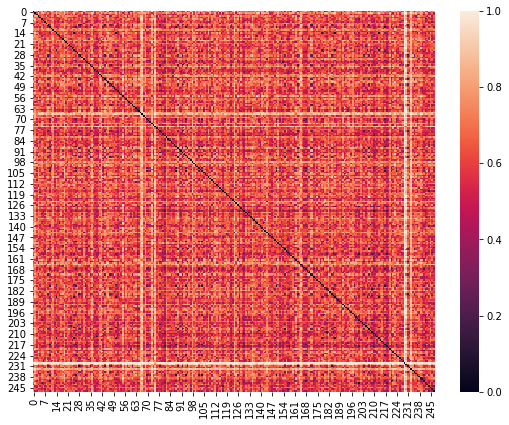

In [172]:
distances = spatial.distance.squareform(spatial.distance.pdist(W,'cosine')) # W
plt.figure(figsize=[9,7])
sns.heatmap(distances)

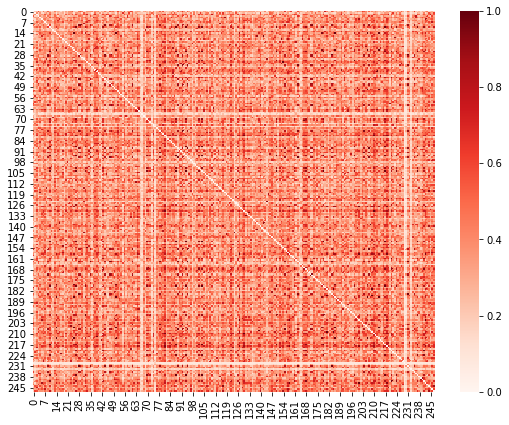

In [173]:
kernel_width = np.mean(distances)#distances.mean()

def kernel(x):
    return np.exp(- np.power(x/kernel_width,2))

# applying the kernel to the distances matrix :
weights = kernel(distances)
# setting the diagonal (self-loops) weights to 0 :
weights[range(len(weights)),range(len(weights))] = 0

# displaying a subset of the weights matrix :
plt.figure(figsize=[9,7])
sns.heatmap(weights,cmap="Reds")

In [174]:
weights_df = pd.DataFrame(weights,columns=c_data.index,index=c_data.index)

In [175]:
country = 'France'
weights_df[country].loc[weights_df[country] >= 0.7]

name
Guernsey            0.755302
India               0.756738
Sri Lanka           0.779551
Marshall Islands    0.700051
Swaziland           0.779552
Seychelles          0.707041
Tonga               0.716667
Name: France, dtype: float64

In [176]:
weights_df

name,Aruba,Afghanistan,Angola,Anguilla,Åland Islands,Albania,Andorra,United Arab Emirates,Argentina,Armenia,...,British Virgin Islands,United States Virgin Islands,Vietnam,Vanuatu,Wallis and Futuna,Samoa,Yemen,South Africa,Zambia,Zimbabwe
name,,,,,,,,,,,,,,,,,,,,,
Aruba,0.000000,0.198771,0.235880,0.561115,0.261435,0.170740,0.433465,0.217722,0.256946,0.516766,...,0.271688,0.145460,0.264729,0.211443,0.342588,0.441579,0.155888,0.195817,0.273160,0.161878
Afghanistan,0.198771,0.000000,0.395867,0.156273,0.366870,0.151558,0.140900,0.271369,0.371872,0.225808,...,0.260002,0.175000,0.196194,0.436318,0.150442,0.224462,0.582279,0.432667,0.321832,0.619705
Angola,0.235880,0.395867,0.000000,0.177681,0.316524,0.364456,0.294928,0.558721,0.355835,0.331007,...,0.490663,0.200683,0.318669,0.548745,0.362379,0.290803,0.534741,0.754194,0.365241,0.566410
Anguilla,0.561115,0.156273,0.177681,0.000000,0.418103,0.256587,0.367453,0.395491,0.151097,0.477524,...,0.194031,0.268590,0.270358,0.337581,0.366205,0.645444,0.292670,0.171802,0.599826,0.311405
Åland Islands,0.261435,0.366870,0.316524,0.418103,0.000000,0.284988,0.330418,0.356686,0.455693,0.275128,...,0.310735,0.456443,0.578936,0.463645,0.451788,0.334233,0.587157,0.300120,0.466440,0.371545
Albania,0.170740,0.151558,0.364456,0.256587,0.284988,0.000000,0.416314,0.469873,0.321509,0.350327,...,0.173051,0.273044,0.368292,0.266222,0.861786,0.411593,0.431899,0.502985,0.577713,0.370596
Andorra,0.433465,0.140900,0.294928,0.367453,0.330418,0.416314,0.000000,0.358645,0.219270,0.540504,...,0.331579,0.273197,0.422097,0.366257,0.589285,0.585846,0.284621,0.217120,0.452618,0.316618
United Arab Emirates,0.217722,0.271369,0.558721,0.395491,0.356686,0.469873,0.358645,0.000000,0.297820,0.353498,...,0.309575,0.310903,0.487529,0.363842,0.568842,0.416365,0.613135,0.430991,0.784555,0.485369
Argentina,0.256946,0.371872,0.355835,0.151097,0.455693,0.321509,0.219270,0.297820,0.000000,0.277591,...,0.644434,0.257990,0.411131,0.387883,0.293154,0.197118,0.461237,0.436947,0.309050,0.347757
